In [1]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd
from collections import defaultdict

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype
from torchvision import transforms

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
from tqdm import trange
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

# Set matplotlib style for better visuals
#plt.style.use('fivethirtyeight')

## Architecture class

In [2]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")
        
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

        # Couting the size of the loaders
        if self.train_loader is not None:
            self.train_size = len(self.train_loader.dataset)
            print(f"Train loader size: {self.train_size} samples")

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42, patience=15, min_delta=1e-5):
        # To ensure reproducibility of the training process
        self.set_seed(seed)
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_state = None

        for epoch in trange(n_epochs, desc="Training Progress"):
            # Keeps track of the numbers of epochs
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                # Print the losses for the current epoch
                print(f"Epoch {epoch+1}/{n_epochs}, "
                      f"Training Loss: {loss:.4f}, "
                      f"Validation Loss: {val_loss:.4f}")
            
            # Early Stopping Logic
            if val_loss + min_delta < best_val_loss:
                best_val_loss = val_loss
                best_state = deepcopy(self.model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model weights
        if best_state is not None:
            self.model.load_state_dict(best_state)
                    

    # def train(self, n_epochs, seed=42):
    #     # To ensure reproducibility of the training process
    #     self.set_seed(seed)

    #     for epoch in range(n_epochs):
    #         # Keeps track of the numbers of epochs
    #         # by updating the corresponding attribute
    #         self.total_epochs += 1

    #         # inner loop
    #         # Performs training using mini-batches
    #         loss = self._mini_batch(validation=False)
    #         self.losses.append(loss)

    #         # VALIDATION
    #         # no gradients in validation!
    #         with torch.no_grad():
    #             # Performs evaluation using mini-batches
    #             val_loss = self._mini_batch(validation=True)
    #             self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename, weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)    

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer



# Data Generation

This dataset was created by combining two datasets from Kaggle: [Thitinan Kliangsuwan. Cloud Type Classification 3, 2022.](https://kaggle.com/competitions/cloud-type-classification-3) and [Howard-Cloud-X](https://www.kaggle.com/datasets/imbikramsaha/howard-cloudx). 


The two original datasets showed several inconsistencies regarding the previously labeled cloud types. Therefore, a manual selection of images was necessary to obtain the best dataset for training and validation. Additionally, due to the similarity between some cloud classes, five types were selected along with the “Clear Sky” class. The chosen classes were: Cirrus, Altocumulus, Cumulonimbus, Cumulus, Nimbostratus, and Clear Sky.

In [41]:
# Path to the dataset
folder='../dataset/clouds_types'

In [42]:
# Function to create a figure with images of different cloud types

def figure1(folder):
    cirrus = Image.open(f'{folder}/Cirrus/cirrus-004.jpg')
    altocumulus = Image.open(f'{folder}/Altocumulus/altocumulus-000.jpg')
    cumulonimbus = Image.open(f'{folder}/Cumulonimbus/cumulonimbus-030.jpg')
    cumulus = Image.open(f'{folder}/Cumulus/cumulus-000.jpg')
    nimbostratus = Image.open(f'{folder}/Nimbostratus/nimbostratus-000.jpg')
    clear_sky = Image.open(f'{folder}/Clear_Sky/clear_sky-008.jpg')


    images = [cirrus, altocumulus,cumulonimbus, cumulus, nimbostratus,clear_sky]
    titles = ['Cirrus','Altocumulus','Cumulonimbus', 'Cumulus', 'Nimbostratus',"Clear Sky"]

    fig, axs = plt.subplots(2, 3, figsize=(12, 5))
    for ax, image, title in zip(axs.flat, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig

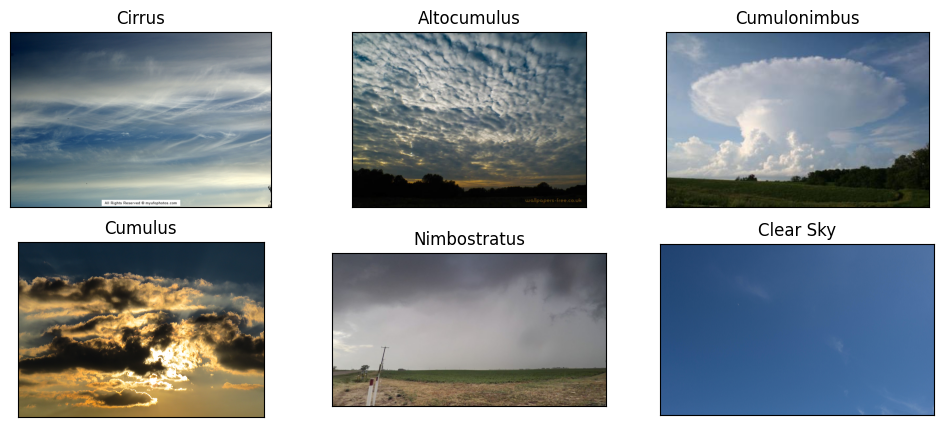

In [43]:
fig = figure1(folder)

# Data Preparation

## ImageFolder

In [3]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 128×128 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]

temp_transform = transforms.Compose([
    transforms.Resize((128,128)),        # Resize each image to 128×128
    ToImage(),                         # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True) # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'Cloud types' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root='../dataset/clouds_types',  # Path to the dataset
    transform=temp_transform      # Apply the preprocessing pipeline to every image
)

In [4]:
# Looking the shape of every images
temp_dataset[len(temp_dataset)-1][0].shape

torch.Size([3, 128, 128])

In [5]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 657 images
Number of classes: 6


## Standardization

In [6]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [7]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 6.5845,  7.1045,  7.9006],
        [ 3.1239,  2.6483,  2.4395]])

In [8]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[657.0000, 657.0000, 657.0000],
        [286.9017, 329.4192, 386.5170],
        [120.7267, 104.9557,  93.1730]])

In [9]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.4367), tensor(0.5014), tensor(0.5883)], std=[tensor(0.1838), tensor(0.1597), tensor(0.1418)], inplace=False)

## Real Dataset

In [10]:
# Define a pipeline of image transformations:
# 1) Resize each image to 128×128 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
train_composer = transforms.Compose([
    transforms.Resize((128,128)),       # 1) Resize para 128×128
    transforms.RandomHorizontalFlip(),  # 2) Flip horizontal aleatório
    transforms.RandomRotation(15),      # 3) Rotação aleatória de até ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05), # 4) Pequenas variações de cor/luz
    ToImage(),                          # 5) Garante tipo PIL/RGB
    ToDtype(torch.float32, scale=True), # 6) Cast para float e normaliza para [0,1]
    normalizer                          # 7) Normalização customizada (média/desvio)
])

val_composer = transforms.Compose([
    transforms.Resize((128,128)),       # 1) Resize
    ToImage(),                          # 2) PIL/RGB
    ToDtype(torch.float32, scale=True), # 3) Float e [0,1]
    normalizer                          # 4) Normalização
])

# Instantiate training and validation datasets from folders:
# - 'clouds_types' contains subfolders per class for training
# - 'clouds_types_test' likewise for validation
train_data = ImageFolder(root='../dataset/clouds_types', transform=train_composer)
val_data   = ImageFolder(root='../dataset/clouds_types_test', transform=val_composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=8)  # no shuffle for validation

In [11]:
# Access a batch of data and check its shape
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: torch.Size([8, 3, 128, 128]), Labels shape: torch.Size([8])


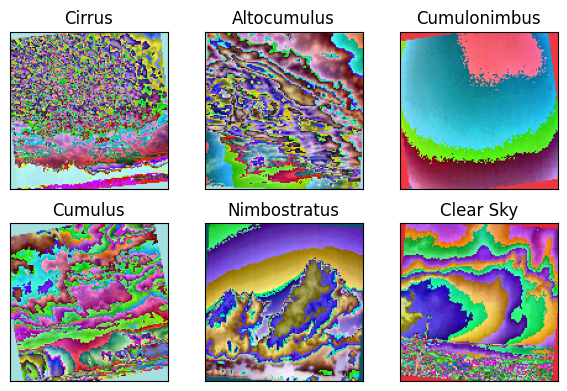

In [12]:
# Function to get one sample per class from the dataset

def get_one_per_class(dataset, num_classes):
    samples = defaultdict(list)
    for img, label in dataset:
        if label not in samples:
            samples[label] = img
        if len(samples) == num_classes:
            break
    images = [samples[i] for i in range(num_classes)]
    labels = list(range(num_classes))
    return images, labels

# Creating the plot

def figure2(first_images, first_labels):
    fig, axs = plt.subplots(2, 3, figsize=(6, 4))
    titles = ['Cirrus','Altocumulus','Cumulonimbus', 'Cumulus', 'Nimbostratus',"Clear Sky"]
    
    axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing
    
    for i in range(6):
        # Ensure first_images[i] is a PyTorch tensor before using ToPILImage
        image_tensor = torch.tensor(first_images[i]) if isinstance(first_images[i], np.ndarray) else first_images[i]
        image, label = ToPILImage()(image_tensor), first_labels[i]
        
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    
    # Hide any unused subplots
    # for j in range(6, len(axs)):
    #     axs[j].axis('off')
    
    fig.tight_layout()
    return fig

torch.manual_seed(88)
first_images, first_labels = get_one_per_class(train_loader.dataset, 6)
fig = figure2(first_images, first_labels)

# Creating the Model

The following changes were implemented to improve the model's performance:

- **Input Size Adjustment**: The input size was increased from 28×28 to 128×128 to capture more details in the images.
- **Optimizer Update**: The optimizer was changed from `Adam` to `AdamW` for better weight decay handling and generalization.
- **Activation Function**: The `ReLU` activation function was replaced with `ELU` to improve training dynamics and convergence.
- **Batch Normalization**: Batch normalization layers were added to stabilize and accelerate training.
- **Early Stopping**: An early stopping mechanism was introduced to prevent overfitting by halting training when validation loss stops improving.


In [13]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.bn1 = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        self.bn2 = nn.BatchNorm2d(n_feature)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 6) # here we set the 6 classes in total
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # NEW: adaptively pool to 5x5
        x = F.adaptive_avg_pool2d(x, (5, 5))
        x = nn.Flatten()(x)
        return x


    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.elu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (6)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Case Study

## Model Configuration

Keeping ```n_feature``` = 5 and ```p``` = 0.3

In [14]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.AdamW(model_cnn2.parameters(), lr=3e-4)

In [15]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0.01,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'decoupled_weight_decay': True,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}]}

## Model Training

Since we implemented an early stopping mechanism, we can train the model for a maximum of 200 epochs, but it will stop earlier if the validation loss  does not improve for 15 epochs.

In [16]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(200)

Using device: cuda
Train loader size: 657 samples


Training Progress:   0%|          | 1/200 [00:26<1:28:40, 26.73s/it]

Epoch 1/200, Training Loss: 1.6653, Validation Loss: 1.4824


Training Progress:   1%|          | 2/200 [00:53<1:28:35, 26.85s/it]

Epoch 2/200, Training Loss: 1.5087, Validation Loss: 1.3560


Training Progress:   2%|▏         | 3/200 [01:20<1:27:25, 26.63s/it]

Epoch 3/200, Training Loss: 1.4073, Validation Loss: 1.2699


Training Progress:   2%|▏         | 4/200 [01:46<1:26:27, 26.46s/it]

Epoch 4/200, Training Loss: 1.3211, Validation Loss: 1.2017


Training Progress:   2%|▎         | 5/200 [02:12<1:25:50, 26.41s/it]

Epoch 5/200, Training Loss: 1.2424, Validation Loss: 1.1493


Training Progress:   3%|▎         | 6/200 [02:39<1:25:28, 26.43s/it]

Epoch 6/200, Training Loss: 1.1906, Validation Loss: 1.1048


Training Progress:   4%|▎         | 7/200 [03:05<1:24:55, 26.40s/it]

Epoch 7/200, Training Loss: 1.1851, Validation Loss: 1.0869


Training Progress:   4%|▍         | 8/200 [03:31<1:24:19, 26.35s/it]

Epoch 8/200, Training Loss: 1.1055, Validation Loss: 1.1053


Training Progress:   4%|▍         | 9/200 [03:58<1:23:56, 26.37s/it]

Epoch 9/200, Training Loss: 1.1120, Validation Loss: 1.0522


Training Progress:   5%|▌         | 10/200 [04:24<1:23:25, 26.34s/it]

Epoch 10/200, Training Loss: 1.0797, Validation Loss: 1.0203


Training Progress:   6%|▌         | 11/200 [04:51<1:23:22, 26.47s/it]

Epoch 11/200, Training Loss: 1.0509, Validation Loss: 0.9951


Training Progress:   6%|▌         | 12/200 [05:17<1:22:42, 26.39s/it]

Epoch 12/200, Training Loss: 1.0706, Validation Loss: 1.0035


Training Progress:   6%|▋         | 13/200 [05:43<1:22:13, 26.38s/it]

Epoch 13/200, Training Loss: 1.0520, Validation Loss: 1.0393


Training Progress:   7%|▋         | 14/200 [06:09<1:21:32, 26.30s/it]

Epoch 14/200, Training Loss: 1.0450, Validation Loss: 0.9556


Training Progress:   8%|▊         | 15/200 [06:36<1:21:02, 26.29s/it]

Epoch 15/200, Training Loss: 1.0098, Validation Loss: 0.9513


Training Progress:   8%|▊         | 16/200 [07:02<1:20:37, 26.29s/it]

Epoch 16/200, Training Loss: 0.9824, Validation Loss: 0.9229


Training Progress:   8%|▊         | 17/200 [07:28<1:20:12, 26.30s/it]

Epoch 17/200, Training Loss: 1.0376, Validation Loss: 0.9135


Training Progress:   9%|▉         | 18/200 [07:54<1:19:32, 26.22s/it]

Epoch 18/200, Training Loss: 0.9818, Validation Loss: 0.9563


Training Progress:  10%|▉         | 19/200 [08:20<1:18:54, 26.16s/it]

Epoch 19/200, Training Loss: 0.9688, Validation Loss: 0.9043


Training Progress:  10%|█         | 20/200 [08:46<1:18:20, 26.11s/it]

Epoch 20/200, Training Loss: 0.9581, Validation Loss: 0.9457


Training Progress:  10%|█         | 21/200 [09:12<1:17:47, 26.07s/it]

Epoch 21/200, Training Loss: 0.9993, Validation Loss: 0.9696


Training Progress:  11%|█         | 22/200 [09:38<1:17:18, 26.06s/it]

Epoch 22/200, Training Loss: 0.9636, Validation Loss: 0.9465


Training Progress:  12%|█▏        | 23/200 [10:04<1:16:47, 26.03s/it]

Epoch 23/200, Training Loss: 0.9847, Validation Loss: 0.9156


Training Progress:  12%|█▏        | 24/200 [10:30<1:16:30, 26.08s/it]

Epoch 24/200, Training Loss: 0.9422, Validation Loss: 0.9575


Training Progress:  12%|█▎        | 25/200 [10:56<1:16:07, 26.10s/it]

Epoch 25/200, Training Loss: 0.9511, Validation Loss: 0.9520


Training Progress:  13%|█▎        | 26/200 [11:23<1:15:58, 26.20s/it]

Epoch 26/200, Training Loss: 0.9469, Validation Loss: 0.9575


Training Progress:  14%|█▎        | 27/200 [11:49<1:15:47, 26.29s/it]

Epoch 27/200, Training Loss: 0.9384, Validation Loss: 0.9174


Training Progress:  14%|█▍        | 28/200 [12:16<1:15:27, 26.32s/it]

Epoch 28/200, Training Loss: 0.9217, Validation Loss: 0.8914


Training Progress:  14%|█▍        | 29/200 [12:42<1:14:55, 26.29s/it]

Epoch 29/200, Training Loss: 0.9030, Validation Loss: 0.9283


Training Progress:  15%|█▌        | 30/200 [13:08<1:14:33, 26.31s/it]

Epoch 30/200, Training Loss: 0.9420, Validation Loss: 0.8854


Training Progress:  16%|█▌        | 31/200 [13:35<1:14:12, 26.34s/it]

Epoch 31/200, Training Loss: 0.9176, Validation Loss: 0.9133


Training Progress:  16%|█▌        | 32/200 [14:01<1:13:51, 26.38s/it]

Epoch 32/200, Training Loss: 0.9093, Validation Loss: 0.8475


Training Progress:  16%|█▋        | 33/200 [14:28<1:13:20, 26.35s/it]

Epoch 33/200, Training Loss: 0.8942, Validation Loss: 0.9705


Training Progress:  17%|█▋        | 34/200 [14:54<1:12:42, 26.28s/it]

Epoch 34/200, Training Loss: 0.8783, Validation Loss: 0.8608


Training Progress:  18%|█▊        | 35/200 [15:20<1:12:10, 26.24s/it]

Epoch 35/200, Training Loss: 0.8926, Validation Loss: 0.8450


Training Progress:  18%|█▊        | 36/200 [15:46<1:11:51, 26.29s/it]

Epoch 36/200, Training Loss: 0.9776, Validation Loss: 0.8874


Training Progress:  18%|█▊        | 37/200 [16:12<1:11:14, 26.23s/it]

Epoch 37/200, Training Loss: 0.8688, Validation Loss: 0.8509


Training Progress:  19%|█▉        | 38/200 [16:39<1:11:12, 26.37s/it]

Epoch 38/200, Training Loss: 0.8729, Validation Loss: 0.8388


Training Progress:  20%|█▉        | 39/200 [17:06<1:10:58, 26.45s/it]

Epoch 39/200, Training Loss: 0.9097, Validation Loss: 0.8804


Training Progress:  20%|██        | 40/200 [17:32<1:10:11, 26.32s/it]

Epoch 40/200, Training Loss: 0.9091, Validation Loss: 0.8998


Training Progress:  20%|██        | 41/200 [17:58<1:09:37, 26.27s/it]

Epoch 41/200, Training Loss: 0.8802, Validation Loss: 0.8258


Training Progress:  21%|██        | 42/200 [18:24<1:09:06, 26.24s/it]

Epoch 42/200, Training Loss: 0.8841, Validation Loss: 0.8242


Training Progress:  22%|██▏       | 43/200 [18:50<1:08:36, 26.22s/it]

Epoch 43/200, Training Loss: 0.8854, Validation Loss: 0.8658


Training Progress:  22%|██▏       | 44/200 [19:17<1:08:16, 26.26s/it]

Epoch 44/200, Training Loss: 0.8436, Validation Loss: 0.8273


Training Progress:  22%|██▎       | 45/200 [19:43<1:07:49, 26.26s/it]

Epoch 45/200, Training Loss: 0.8621, Validation Loss: 0.8420


Training Progress:  23%|██▎       | 46/200 [20:09<1:07:16, 26.21s/it]

Epoch 46/200, Training Loss: 0.8549, Validation Loss: 0.7946


Training Progress:  24%|██▎       | 47/200 [20:35<1:06:53, 26.23s/it]

Epoch 47/200, Training Loss: 0.8349, Validation Loss: 0.8246


Training Progress:  24%|██▍       | 48/200 [21:01<1:06:24, 26.22s/it]

Epoch 48/200, Training Loss: 0.8530, Validation Loss: 0.8474


Training Progress:  24%|██▍       | 49/200 [21:28<1:05:58, 26.21s/it]

Epoch 49/200, Training Loss: 0.8670, Validation Loss: 0.8326


Training Progress:  25%|██▌       | 50/200 [21:54<1:05:20, 26.14s/it]

Epoch 50/200, Training Loss: 0.8709, Validation Loss: 0.8291


Training Progress:  26%|██▌       | 51/200 [22:20<1:04:58, 26.16s/it]

Epoch 51/200, Training Loss: 0.8241, Validation Loss: 0.8068


Training Progress:  26%|██▌       | 52/200 [22:46<1:04:36, 26.19s/it]

Epoch 52/200, Training Loss: 0.7958, Validation Loss: 0.8145


Training Progress:  26%|██▋       | 53/200 [23:13<1:04:30, 26.33s/it]

Epoch 53/200, Training Loss: 0.8304, Validation Loss: 0.8268


Training Progress:  27%|██▋       | 54/200 [23:39<1:04:09, 26.37s/it]

Epoch 54/200, Training Loss: 0.8201, Validation Loss: 0.8216


Training Progress:  28%|██▊       | 55/200 [24:06<1:03:45, 26.38s/it]

Epoch 55/200, Training Loss: 0.8104, Validation Loss: 0.8137


Training Progress:  28%|██▊       | 56/200 [24:32<1:03:03, 26.27s/it]

Epoch 56/200, Training Loss: 0.8755, Validation Loss: 0.7954


Training Progress:  28%|██▊       | 57/200 [24:58<1:02:29, 26.22s/it]

Epoch 57/200, Training Loss: 0.8842, Validation Loss: 0.8182


Training Progress:  29%|██▉       | 58/200 [25:24<1:02:10, 26.27s/it]

Epoch 58/200, Training Loss: 0.8989, Validation Loss: 0.8087


Training Progress:  30%|██▉       | 59/200 [25:50<1:01:38, 26.23s/it]

Epoch 59/200, Training Loss: 0.8307, Validation Loss: 0.8105


Training Progress:  30%|███       | 60/200 [26:16<1:01:10, 26.22s/it]

Epoch 60/200, Training Loss: 0.8665, Validation Loss: 0.7569


Training Progress:  30%|███       | 61/200 [26:43<1:00:48, 26.25s/it]

Epoch 61/200, Training Loss: 0.8106, Validation Loss: 0.7887


Training Progress:  31%|███       | 62/200 [27:09<1:00:27, 26.29s/it]

Epoch 62/200, Training Loss: 0.8483, Validation Loss: 0.7924


Training Progress:  32%|███▏      | 63/200 [27:35<1:00:05, 26.32s/it]

Epoch 63/200, Training Loss: 0.8280, Validation Loss: 0.8127


Training Progress:  32%|███▏      | 64/200 [28:02<59:36, 26.30s/it]  

Epoch 64/200, Training Loss: 0.8274, Validation Loss: 0.7706


Training Progress:  32%|███▎      | 65/200 [28:28<59:15, 26.33s/it]

Epoch 65/200, Training Loss: 0.8407, Validation Loss: 0.8786


Training Progress:  33%|███▎      | 66/200 [28:55<58:58, 26.41s/it]

Epoch 66/200, Training Loss: 0.8343, Validation Loss: 0.7904


Training Progress:  34%|███▎      | 67/200 [29:21<58:36, 26.44s/it]

Epoch 67/200, Training Loss: 0.8399, Validation Loss: 0.7499


Training Progress:  34%|███▍      | 68/200 [29:47<57:59, 26.36s/it]

Epoch 68/200, Training Loss: 0.8001, Validation Loss: 0.7826


Training Progress:  34%|███▍      | 69/200 [30:14<57:32, 26.36s/it]

Epoch 69/200, Training Loss: 0.8148, Validation Loss: 0.8186


Training Progress:  35%|███▌      | 70/200 [30:40<57:05, 26.35s/it]

Epoch 70/200, Training Loss: 0.8097, Validation Loss: 0.8636


Training Progress:  36%|███▌      | 71/200 [31:07<56:43, 26.38s/it]

Epoch 71/200, Training Loss: 0.7911, Validation Loss: 0.7511


Training Progress:  36%|███▌      | 72/200 [31:33<56:19, 26.40s/it]

Epoch 72/200, Training Loss: 0.7788, Validation Loss: 0.7404


Training Progress:  36%|███▋      | 73/200 [31:59<55:44, 26.33s/it]

Epoch 73/200, Training Loss: 0.7800, Validation Loss: 0.7761


Training Progress:  37%|███▋      | 74/200 [32:25<55:13, 26.30s/it]

Epoch 74/200, Training Loss: 0.8168, Validation Loss: 0.7176


Training Progress:  38%|███▊      | 75/200 [32:52<54:50, 26.33s/it]

Epoch 75/200, Training Loss: 0.8051, Validation Loss: 0.7322


Training Progress:  38%|███▊      | 76/200 [33:18<54:16, 26.26s/it]

Epoch 76/200, Training Loss: 0.8328, Validation Loss: 0.7478


Training Progress:  38%|███▊      | 77/200 [33:44<53:49, 26.25s/it]

Epoch 77/200, Training Loss: 0.8319, Validation Loss: 0.7469


Training Progress:  39%|███▉      | 78/200 [34:11<53:29, 26.31s/it]

Epoch 78/200, Training Loss: 0.8109, Validation Loss: 0.7638


Training Progress:  40%|███▉      | 79/200 [34:37<53:01, 26.29s/it]

Epoch 79/200, Training Loss: 0.8245, Validation Loss: 0.7361


Training Progress:  40%|████      | 80/200 [35:03<52:32, 26.27s/it]

Epoch 80/200, Training Loss: 0.7859, Validation Loss: 0.7736


Training Progress:  40%|████      | 81/200 [35:29<52:12, 26.32s/it]

Epoch 81/200, Training Loss: 0.7998, Validation Loss: 0.7854


Training Progress:  41%|████      | 82/200 [35:56<51:48, 26.34s/it]

Epoch 82/200, Training Loss: 0.8091, Validation Loss: 0.7410


Training Progress:  42%|████▏     | 83/200 [36:22<51:26, 26.38s/it]

Epoch 83/200, Training Loss: 0.8234, Validation Loss: 0.8044


Training Progress:  42%|████▏     | 84/200 [36:49<50:59, 26.38s/it]

Epoch 84/200, Training Loss: 0.8189, Validation Loss: 0.7312


Training Progress:  42%|████▎     | 85/200 [37:15<50:35, 26.40s/it]

Epoch 85/200, Training Loss: 0.8030, Validation Loss: 0.7553


Training Progress:  43%|████▎     | 86/200 [37:42<50:10, 26.41s/it]

Epoch 86/200, Training Loss: 0.8350, Validation Loss: 0.7860


Training Progress:  44%|████▎     | 87/200 [38:08<49:42, 26.40s/it]

Epoch 87/200, Training Loss: 0.8120, Validation Loss: 0.7100


Training Progress:  44%|████▍     | 88/200 [38:34<49:22, 26.45s/it]

Epoch 88/200, Training Loss: 0.8073, Validation Loss: 0.7332


Training Progress:  44%|████▍     | 89/200 [39:01<48:51, 26.41s/it]

Epoch 89/200, Training Loss: 0.8055, Validation Loss: 0.7787


Training Progress:  45%|████▌     | 90/200 [39:27<48:21, 26.38s/it]

Epoch 90/200, Training Loss: 0.7711, Validation Loss: 0.7194


Training Progress:  46%|████▌     | 91/200 [39:53<47:53, 26.36s/it]

Epoch 91/200, Training Loss: 0.8087, Validation Loss: 0.7145


Training Progress:  46%|████▌     | 92/200 [40:20<47:26, 26.36s/it]

Epoch 92/200, Training Loss: 0.7960, Validation Loss: 0.7255


Training Progress:  46%|████▋     | 93/200 [40:46<47:05, 26.41s/it]

Epoch 93/200, Training Loss: 0.7547, Validation Loss: 0.6983


Training Progress:  47%|████▋     | 94/200 [41:13<46:37, 26.39s/it]

Epoch 94/200, Training Loss: 0.7529, Validation Loss: 0.7245


Training Progress:  48%|████▊     | 95/200 [41:39<46:16, 26.45s/it]

Epoch 95/200, Training Loss: 0.7391, Validation Loss: 0.7271


Training Progress:  48%|████▊     | 96/200 [42:06<45:48, 26.42s/it]

Epoch 96/200, Training Loss: 0.7679, Validation Loss: 0.7415


Training Progress:  48%|████▊     | 97/200 [42:32<45:24, 26.45s/it]

Epoch 97/200, Training Loss: 0.7982, Validation Loss: 0.7163


Training Progress:  49%|████▉     | 98/200 [42:59<44:58, 26.45s/it]

Epoch 98/200, Training Loss: 0.7860, Validation Loss: 0.7344


Training Progress:  50%|████▉     | 99/200 [43:25<44:27, 26.41s/it]

Epoch 99/200, Training Loss: 0.7842, Validation Loss: 0.7090


Training Progress:  50%|█████     | 100/200 [43:51<44:01, 26.41s/it]

Epoch 100/200, Training Loss: 0.7436, Validation Loss: 0.6988


Training Progress:  50%|█████     | 101/200 [44:18<43:36, 26.43s/it]

Epoch 101/200, Training Loss: 0.7858, Validation Loss: 0.7018


Training Progress:  51%|█████     | 102/200 [44:44<43:10, 26.43s/it]

Epoch 102/200, Training Loss: 0.7781, Validation Loss: 0.7233


Training Progress:  52%|█████▏    | 103/200 [45:11<42:43, 26.43s/it]

Epoch 103/200, Training Loss: 0.7958, Validation Loss: 0.7032


Training Progress:  52%|█████▏    | 104/200 [45:37<42:16, 26.42s/it]

Epoch 104/200, Training Loss: 0.8217, Validation Loss: 0.6798


Training Progress:  52%|█████▎    | 105/200 [46:03<41:49, 26.42s/it]

Epoch 105/200, Training Loss: 0.7681, Validation Loss: 0.7809


Training Progress:  53%|█████▎    | 106/200 [46:30<41:22, 26.41s/it]

Epoch 106/200, Training Loss: 0.7795, Validation Loss: 0.7074


Training Progress:  54%|█████▎    | 107/200 [46:56<40:58, 26.44s/it]

Epoch 107/200, Training Loss: 0.7600, Validation Loss: 0.7721


Training Progress:  54%|█████▍    | 108/200 [47:23<40:33, 26.45s/it]

Epoch 108/200, Training Loss: 0.7973, Validation Loss: 0.7180


Training Progress:  55%|█████▍    | 109/200 [47:49<40:05, 26.44s/it]

Epoch 109/200, Training Loss: 0.7730, Validation Loss: 0.7422


Training Progress:  55%|█████▌    | 110/200 [48:16<39:47, 26.53s/it]

Epoch 110/200, Training Loss: 0.7615, Validation Loss: 0.7023


Training Progress:  56%|█████▌    | 111/200 [48:43<39:29, 26.62s/it]

Epoch 111/200, Training Loss: 0.7575, Validation Loss: 0.7325


Training Progress:  56%|█████▌    | 112/200 [49:09<38:58, 26.57s/it]

Epoch 112/200, Training Loss: 0.7782, Validation Loss: 0.7735


Training Progress:  56%|█████▋    | 113/200 [49:36<38:25, 26.50s/it]

Epoch 113/200, Training Loss: 0.7845, Validation Loss: 0.7336


Training Progress:  57%|█████▋    | 114/200 [50:02<37:59, 26.50s/it]

Epoch 114/200, Training Loss: 0.7516, Validation Loss: 0.6758


Training Progress:  57%|█████▊    | 115/200 [50:29<37:34, 26.52s/it]

Epoch 115/200, Training Loss: 0.7779, Validation Loss: 0.7377


Training Progress:  58%|█████▊    | 116/200 [50:55<37:13, 26.59s/it]

Epoch 116/200, Training Loss: 0.7696, Validation Loss: 0.7243


Training Progress:  58%|█████▊    | 117/200 [51:22<36:45, 26.57s/it]

Epoch 117/200, Training Loss: 0.7859, Validation Loss: 0.7252


Training Progress:  59%|█████▉    | 118/200 [51:49<36:19, 26.58s/it]

Epoch 118/200, Training Loss: 0.7789, Validation Loss: 0.7781


Training Progress:  60%|█████▉    | 119/200 [52:15<35:46, 26.50s/it]

Epoch 119/200, Training Loss: 0.7612, Validation Loss: 0.7121


Training Progress:  60%|██████    | 120/200 [52:42<35:26, 26.58s/it]

Epoch 120/200, Training Loss: 0.7425, Validation Loss: 0.7659


Training Progress:  60%|██████    | 121/200 [53:09<35:07, 26.67s/it]

Epoch 121/200, Training Loss: 0.7310, Validation Loss: 0.7384


Training Progress:  61%|██████    | 122/200 [53:35<34:32, 26.57s/it]

Epoch 122/200, Training Loss: 0.7326, Validation Loss: 0.7156


Training Progress:  62%|██████▏   | 123/200 [54:01<33:57, 26.46s/it]

Epoch 123/200, Training Loss: 0.7409, Validation Loss: 0.7092


Training Progress:  62%|██████▏   | 124/200 [54:27<33:28, 26.43s/it]

Epoch 124/200, Training Loss: 0.7698, Validation Loss: 0.6512


Training Progress:  62%|██████▎   | 125/200 [54:54<33:06, 26.49s/it]

Epoch 125/200, Training Loss: 0.7879, Validation Loss: 0.6904


Training Progress:  63%|██████▎   | 126/200 [55:20<32:38, 26.46s/it]

Epoch 126/200, Training Loss: 0.7473, Validation Loss: 0.6968


Training Progress:  64%|██████▎   | 127/200 [55:47<32:14, 26.50s/it]

Epoch 127/200, Training Loss: 0.7561, Validation Loss: 0.7533


Training Progress:  64%|██████▍   | 128/200 [56:14<31:55, 26.60s/it]

Epoch 128/200, Training Loss: 0.7574, Validation Loss: 0.7366


Training Progress:  64%|██████▍   | 129/200 [56:40<31:29, 26.61s/it]

Epoch 129/200, Training Loss: 0.7718, Validation Loss: 0.7547


Training Progress:  65%|██████▌   | 130/200 [57:07<30:58, 26.56s/it]

Epoch 130/200, Training Loss: 0.7708, Validation Loss: 0.6603


Training Progress:  66%|██████▌   | 131/200 [57:34<30:34, 26.59s/it]

Epoch 131/200, Training Loss: 0.7829, Validation Loss: 0.7832


Training Progress:  66%|██████▌   | 132/200 [58:00<30:07, 26.58s/it]

Epoch 132/200, Training Loss: 0.7560, Validation Loss: 0.6455


Training Progress:  66%|██████▋   | 133/200 [58:27<29:40, 26.57s/it]

Epoch 133/200, Training Loss: 0.7429, Validation Loss: 0.6735


Training Progress:  67%|██████▋   | 134/200 [58:54<29:18, 26.65s/it]

Epoch 134/200, Training Loss: 0.7178, Validation Loss: 0.7177


Training Progress:  68%|██████▊   | 135/200 [59:20<28:50, 26.62s/it]

Epoch 135/200, Training Loss: 0.7450, Validation Loss: 0.6565


Training Progress:  68%|██████▊   | 136/200 [59:47<28:24, 26.63s/it]

Epoch 136/200, Training Loss: 0.7471, Validation Loss: 0.7113


Training Progress:  68%|██████▊   | 137/200 [1:00:14<28:04, 26.74s/it]

Epoch 137/200, Training Loss: 0.7216, Validation Loss: 0.7263


Training Progress:  69%|██████▉   | 138/200 [1:00:41<27:40, 26.78s/it]

Epoch 138/200, Training Loss: 0.7160, Validation Loss: 0.6988


Training Progress:  70%|██████▉   | 139/200 [1:01:07<27:13, 26.78s/it]

Epoch 139/200, Training Loss: 0.7232, Validation Loss: 0.6409


Training Progress:  70%|███████   | 140/200 [1:01:34<26:41, 26.69s/it]

Epoch 140/200, Training Loss: 0.7296, Validation Loss: 0.7142


Training Progress:  70%|███████   | 141/200 [1:02:00<26:09, 26.60s/it]

Epoch 141/200, Training Loss: 0.7393, Validation Loss: 0.6648


Training Progress:  71%|███████   | 142/200 [1:02:27<25:50, 26.73s/it]

Epoch 142/200, Training Loss: 0.7564, Validation Loss: 0.6643


Training Progress:  72%|███████▏  | 143/200 [1:02:54<25:22, 26.71s/it]

Epoch 143/200, Training Loss: 0.7457, Validation Loss: 0.7109


Training Progress:  72%|███████▏  | 144/200 [1:03:21<24:53, 26.67s/it]

Epoch 144/200, Training Loss: 0.7290, Validation Loss: 0.6812


Training Progress:  72%|███████▎  | 145/200 [1:03:47<24:24, 26.62s/it]

Epoch 145/200, Training Loss: 0.7429, Validation Loss: 0.6778


Training Progress:  73%|███████▎  | 146/200 [1:04:14<23:59, 26.67s/it]

Epoch 146/200, Training Loss: 0.6957, Validation Loss: 0.6772


Training Progress:  74%|███████▎  | 147/200 [1:04:41<23:35, 26.71s/it]

Epoch 147/200, Training Loss: 0.6801, Validation Loss: 0.7047


Training Progress:  74%|███████▍  | 148/200 [1:05:07<23:06, 26.66s/it]

Epoch 148/200, Training Loss: 0.7354, Validation Loss: 0.7788


Training Progress:  74%|███████▍  | 149/200 [1:05:34<22:38, 26.64s/it]

Epoch 149/200, Training Loss: 0.7395, Validation Loss: 0.7158


Training Progress:  75%|███████▌  | 150/200 [1:06:00<22:10, 26.60s/it]

Epoch 150/200, Training Loss: 0.7360, Validation Loss: 0.6972


Training Progress:  76%|███████▌  | 151/200 [1:06:27<21:42, 26.59s/it]

Epoch 151/200, Training Loss: 0.7491, Validation Loss: 0.6933


Training Progress:  76%|███████▌  | 152/200 [1:06:53<21:16, 26.60s/it]

Epoch 152/200, Training Loss: 0.7276, Validation Loss: 0.7028


Training Progress:  76%|███████▋  | 153/200 [1:07:20<20:50, 26.60s/it]

Epoch 153/200, Training Loss: 0.7065, Validation Loss: 0.6881


Training Progress:  76%|███████▋  | 153/200 [1:07:47<20:49, 26.59s/it]

Epoch 154/200, Training Loss: 0.6679, Validation Loss: 0.7807
Early stopping at epoch 154


In [21]:
arch_cnn2.count_parameters()

6996

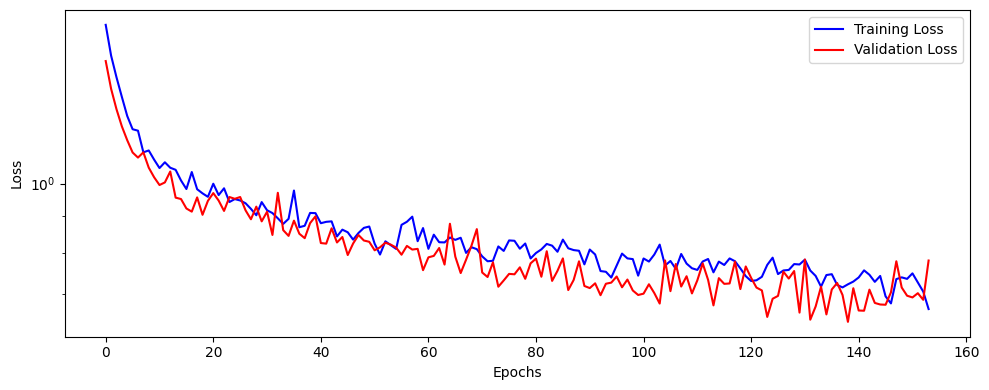

In [28]:
fig = arch_cnn2.plot_losses()

fig.savefig('../images/personal_model/cnn2_losses_v3.png', dpi=300, bbox_inches='tight')

### Accuracy

In [18]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[22, 30],
        [21, 30],
        [24, 24],
        [15, 26],
        [24, 34],
        [18, 21]])

In [19]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([124, 165])

In [22]:
print('Accuracy in train:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0)),
    '\n','Accuracy in val:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0))
)

Accuracy in train: 0.7777777777777778 
 Accuracy in val: 0.7515151515151515


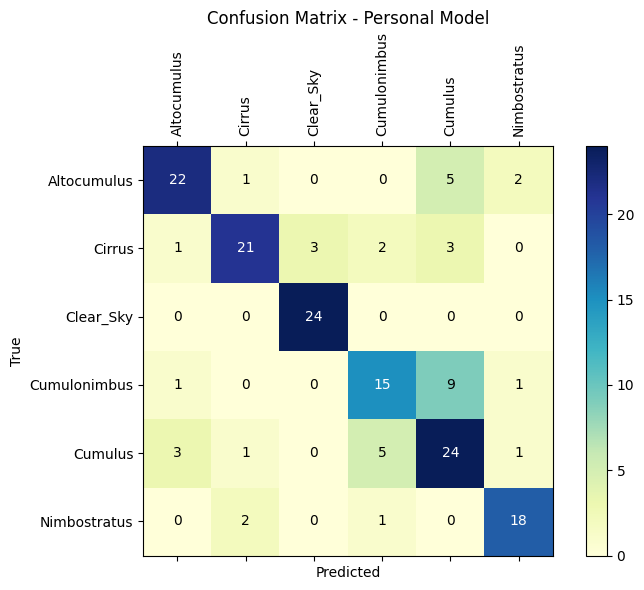

In [ ]:
# Creates a Confusion Matrix
def confusion_matrix(loader, arch):
    # Gets the number of classes
    num_classes = len(loader.dataset.classes)
    # Initializes the confusion matrix
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    # Loops through the mini-batches
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(arch.device)
        y_batch = y_batch.to(arch.device)

        # Gets the predictions
        yhat = arch.predict(x_batch)
        # Converts logits to class indices
        predicted = torch.argmax(torch.tensor(yhat), dim=1)

        # Updates the confusion matrix
        for t, p in zip(y_batch.view(-1), predicted.view(-1)):
            cm[t.long(), p.long()] += 1

    return cm

# Computes the confusion matrix for the validation set
cm = confusion_matrix(val_loader, arch_cnn2)

# Ploting the confusion matrix
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm.numpy(), cmap=plt.cm.YlGnBu)
    fig.colorbar(cax)

    # Set axis labels
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

    # Set ticks and labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=90, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)

    # Annotate each cell with the numeric value
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j].item(), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    return fig

# Plot the confusion matrix
fig_cm = plot_confusion_matrix(cm, arch_cnn2.val_loader.dataset.classes,'Confusion Matrix - Personal Model')

# Save the cm image
fig_cm.savefig('../images/personal_model/C_matrix_v3.png', dpi=300, bbox_inches='tight')

### Regularizing Effect

Running the model with ```p=0```

In [29]:
torch.manual_seed(13)

# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.AdamW(model_cnn2_nodrop.parameters(), lr=3e-4)

# Model Training
arch_cnn2_nodrop = Architecture(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
arch_cnn2_nodrop.set_loaders(train_loader, val_loader)
arch_cnn2_nodrop.train(200)

Using device: cuda
Train loader size: 657 samples


Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training Progress:   0%|          | 1/200 [00:26<1:29:06, 26.87s/it]

Epoch 1/200, Training Loss: 1.5929, Validation Loss: 1.4151


Training Progress:   1%|          | 2/200 [00:53<1:27:58, 26.66s/it]

Epoch 2/200, Training Loss: 1.3870, Validation Loss: 1.2546


Training Progress:   2%|▏         | 3/200 [01:19<1:27:17, 26.58s/it]

Epoch 3/200, Training Loss: 1.2638, Validation Loss: 1.1790


Training Progress:   2%|▏         | 4/200 [01:46<1:26:26, 26.46s/it]

Epoch 4/200, Training Loss: 1.1738, Validation Loss: 1.1215


Training Progress:   2%|▎         | 5/200 [02:12<1:25:57, 26.45s/it]

Epoch 5/200, Training Loss: 1.0896, Validation Loss: 1.0689


Training Progress:   3%|▎         | 6/200 [02:39<1:25:38, 26.49s/it]

Epoch 6/200, Training Loss: 1.0644, Validation Loss: 1.0501


Training Progress:   4%|▎         | 7/200 [03:05<1:24:57, 26.41s/it]

Epoch 7/200, Training Loss: 1.0405, Validation Loss: 1.0490


Training Progress:   4%|▍         | 8/200 [03:31<1:24:27, 26.39s/it]

Epoch 8/200, Training Loss: 0.9808, Validation Loss: 1.0499


Training Progress:   4%|▍         | 9/200 [03:57<1:23:43, 26.30s/it]

Epoch 9/200, Training Loss: 0.9686, Validation Loss: 1.0047


Training Progress:   5%|▌         | 10/200 [04:23<1:23:06, 26.25s/it]

Epoch 10/200, Training Loss: 0.9502, Validation Loss: 0.9821


Training Progress:   6%|▌         | 11/200 [04:50<1:22:32, 26.20s/it]

Epoch 11/200, Training Loss: 0.9352, Validation Loss: 0.9448


Training Progress:   6%|▌         | 12/200 [05:16<1:22:10, 26.23s/it]

Epoch 12/200, Training Loss: 0.9263, Validation Loss: 0.9552


Training Progress:   6%|▋         | 13/200 [05:42<1:21:40, 26.20s/it]

Epoch 13/200, Training Loss: 0.9312, Validation Loss: 0.9890


Training Progress:   7%|▋         | 14/200 [06:08<1:21:12, 26.20s/it]

Epoch 14/200, Training Loss: 0.9171, Validation Loss: 0.9108


Training Progress:   8%|▊         | 15/200 [06:34<1:20:46, 26.20s/it]

Epoch 15/200, Training Loss: 0.8840, Validation Loss: 0.8871


Training Progress:   8%|▊         | 16/200 [07:01<1:20:21, 26.20s/it]

Epoch 16/200, Training Loss: 0.8791, Validation Loss: 0.8725


Training Progress:   8%|▊         | 17/200 [07:27<1:19:41, 26.13s/it]

Epoch 17/200, Training Loss: 0.9178, Validation Loss: 0.8814


Training Progress:   9%|▉         | 18/200 [07:53<1:19:28, 26.20s/it]

Epoch 18/200, Training Loss: 0.8710, Validation Loss: 0.9074


Training Progress:  10%|▉         | 19/200 [08:19<1:18:57, 26.17s/it]

Epoch 19/200, Training Loss: 0.8456, Validation Loss: 0.8618


Training Progress:  10%|█         | 20/200 [08:45<1:18:30, 26.17s/it]

Epoch 20/200, Training Loss: 0.8377, Validation Loss: 0.8691


Training Progress:  10%|█         | 21/200 [09:12<1:18:20, 26.26s/it]

Epoch 21/200, Training Loss: 0.8629, Validation Loss: 0.9040


Training Progress:  11%|█         | 22/200 [09:38<1:17:59, 26.29s/it]

Epoch 22/200, Training Loss: 0.8585, Validation Loss: 0.9372


Training Progress:  12%|█▏        | 23/200 [10:04<1:17:31, 26.28s/it]

Epoch 23/200, Training Loss: 0.8571, Validation Loss: 0.8516


Training Progress:  12%|█▏        | 24/200 [10:31<1:17:07, 26.29s/it]

Epoch 24/200, Training Loss: 0.8161, Validation Loss: 0.8767


Training Progress:  12%|█▎        | 25/200 [10:57<1:16:39, 26.28s/it]

Epoch 25/200, Training Loss: 0.8254, Validation Loss: 0.8663


Training Progress:  13%|█▎        | 26/200 [11:23<1:16:10, 26.27s/it]

Epoch 26/200, Training Loss: 0.8144, Validation Loss: 0.8407


Training Progress:  14%|█▎        | 27/200 [11:49<1:15:40, 26.25s/it]

Epoch 27/200, Training Loss: 0.7981, Validation Loss: 0.8263


Training Progress:  14%|█▍        | 28/200 [12:15<1:15:08, 26.21s/it]

Epoch 28/200, Training Loss: 0.8032, Validation Loss: 0.8192


Training Progress:  14%|█▍        | 29/200 [12:42<1:14:39, 26.20s/it]

Epoch 29/200, Training Loss: 0.7843, Validation Loss: 0.8464


Training Progress:  15%|█▌        | 30/200 [13:08<1:14:06, 26.16s/it]

Epoch 30/200, Training Loss: 0.7940, Validation Loss: 0.8123


Training Progress:  16%|█▌        | 31/200 [13:34<1:14:02, 26.28s/it]

Epoch 31/200, Training Loss: 0.7691, Validation Loss: 0.8111


Training Progress:  16%|█▌        | 32/200 [14:00<1:13:23, 26.21s/it]

Epoch 32/200, Training Loss: 0.7704, Validation Loss: 0.7836


Training Progress:  16%|█▋        | 33/200 [14:27<1:13:00, 26.23s/it]

Epoch 33/200, Training Loss: 0.7735, Validation Loss: 0.8870


Training Progress:  17%|█▋        | 34/200 [14:53<1:12:31, 26.22s/it]

Epoch 34/200, Training Loss: 0.7553, Validation Loss: 0.7675


Training Progress:  18%|█▊        | 35/200 [15:19<1:12:03, 26.20s/it]

Epoch 35/200, Training Loss: 0.7547, Validation Loss: 0.7535


Training Progress:  18%|█▊        | 36/200 [15:45<1:11:43, 26.24s/it]

Epoch 36/200, Training Loss: 0.8070, Validation Loss: 0.7860


Training Progress:  18%|█▊        | 37/200 [16:12<1:11:26, 26.30s/it]

Epoch 37/200, Training Loss: 0.7336, Validation Loss: 0.7667


Training Progress:  19%|█▉        | 38/200 [16:38<1:10:51, 26.24s/it]

Epoch 38/200, Training Loss: 0.7243, Validation Loss: 0.7375


Training Progress:  20%|█▉        | 39/200 [17:04<1:10:20, 26.21s/it]

Epoch 39/200, Training Loss: 0.7580, Validation Loss: 0.7502


Training Progress:  20%|██        | 40/200 [17:30<1:09:55, 26.22s/it]

Epoch 40/200, Training Loss: 0.7402, Validation Loss: 0.7957


Training Progress:  20%|██        | 41/200 [17:57<1:09:37, 26.28s/it]

Epoch 41/200, Training Loss: 0.7184, Validation Loss: 0.7417


Training Progress:  21%|██        | 42/200 [18:23<1:09:17, 26.32s/it]

Epoch 42/200, Training Loss: 0.7040, Validation Loss: 0.7555


Training Progress:  22%|██▏       | 43/200 [18:49<1:08:46, 26.28s/it]

Epoch 43/200, Training Loss: 0.7289, Validation Loss: 0.7700


Training Progress:  22%|██▏       | 44/200 [19:15<1:08:10, 26.22s/it]

Epoch 44/200, Training Loss: 0.6823, Validation Loss: 0.7289


Training Progress:  22%|██▎       | 45/200 [19:41<1:07:36, 26.17s/it]

Epoch 45/200, Training Loss: 0.7151, Validation Loss: 0.7321


Training Progress:  23%|██▎       | 46/200 [20:07<1:07:08, 26.16s/it]

Epoch 46/200, Training Loss: 0.6824, Validation Loss: 0.7061


Training Progress:  24%|██▎       | 47/200 [20:34<1:06:37, 26.13s/it]

Epoch 47/200, Training Loss: 0.6681, Validation Loss: 0.7348


Training Progress:  24%|██▍       | 48/200 [21:00<1:06:11, 26.13s/it]

Epoch 48/200, Training Loss: 0.6837, Validation Loss: 0.7397


Training Progress:  24%|██▍       | 49/200 [21:26<1:05:43, 26.11s/it]

Epoch 49/200, Training Loss: 0.6801, Validation Loss: 0.7752


Training Progress:  25%|██▌       | 50/200 [21:52<1:05:31, 26.21s/it]

Epoch 50/200, Training Loss: 0.6845, Validation Loss: 0.7048


Training Progress:  26%|██▌       | 51/200 [22:18<1:05:03, 26.20s/it]

Epoch 51/200, Training Loss: 0.6547, Validation Loss: 0.7013


Training Progress:  26%|██▌       | 52/200 [22:45<1:04:48, 26.28s/it]

Epoch 52/200, Training Loss: 0.6627, Validation Loss: 0.6971


Training Progress:  26%|██▋       | 53/200 [23:11<1:04:26, 26.30s/it]

Epoch 53/200, Training Loss: 0.6527, Validation Loss: 0.7176


Training Progress:  27%|██▋       | 54/200 [23:38<1:04:15, 26.41s/it]

Epoch 54/200, Training Loss: 0.6357, Validation Loss: 0.7536


Training Progress:  28%|██▊       | 55/200 [24:04<1:03:49, 26.41s/it]

Epoch 55/200, Training Loss: 0.6330, Validation Loss: 0.7473


Training Progress:  28%|██▊       | 56/200 [24:30<1:03:16, 26.36s/it]

Epoch 56/200, Training Loss: 0.6487, Validation Loss: 0.6808


Training Progress:  28%|██▊       | 57/200 [24:57<1:02:54, 26.39s/it]

Epoch 57/200, Training Loss: 0.6674, Validation Loss: 0.6947


Training Progress:  29%|██▉       | 58/200 [25:24<1:03:01, 26.63s/it]

Epoch 58/200, Training Loss: 0.6706, Validation Loss: 0.7017


Training Progress:  30%|██▉       | 59/200 [25:51<1:02:43, 26.69s/it]

Epoch 59/200, Training Loss: 0.6426, Validation Loss: 0.7384


Training Progress:  30%|███       | 60/200 [26:18<1:02:25, 26.76s/it]

Epoch 60/200, Training Loss: 0.6555, Validation Loss: 0.7057


Training Progress:  30%|███       | 61/200 [26:44<1:01:40, 26.62s/it]

Epoch 61/200, Training Loss: 0.6378, Validation Loss: 0.6935


Training Progress:  31%|███       | 62/200 [27:11<1:01:11, 26.61s/it]

Epoch 62/200, Training Loss: 0.6407, Validation Loss: 0.7152


Training Progress:  32%|███▏      | 63/200 [27:38<1:00:52, 26.66s/it]

Epoch 63/200, Training Loss: 0.6262, Validation Loss: 0.7415


Training Progress:  32%|███▏      | 64/200 [28:04<1:00:14, 26.58s/it]

Epoch 64/200, Training Loss: 0.6559, Validation Loss: 0.6878


Training Progress:  32%|███▎      | 65/200 [28:30<59:37, 26.50s/it]  

Epoch 65/200, Training Loss: 0.6433, Validation Loss: 0.7424


Training Progress:  33%|███▎      | 66/200 [28:57<59:29, 26.64s/it]

Epoch 66/200, Training Loss: 0.6492, Validation Loss: 0.6952


Training Progress:  34%|███▎      | 67/200 [29:24<58:54, 26.58s/it]

Epoch 67/200, Training Loss: 0.6433, Validation Loss: 0.6927


Training Progress:  34%|███▍      | 68/200 [29:50<58:04, 26.40s/it]

Epoch 68/200, Training Loss: 0.6389, Validation Loss: 0.6893


Training Progress:  34%|███▍      | 69/200 [30:16<57:46, 26.46s/it]

Epoch 69/200, Training Loss: 0.6412, Validation Loss: 0.6961


Training Progress:  35%|███▌      | 70/200 [30:43<57:26, 26.51s/it]

Epoch 70/200, Training Loss: 0.6101, Validation Loss: 0.7399


Training Progress:  36%|███▌      | 71/200 [31:09<56:44, 26.39s/it]

Epoch 71/200, Training Loss: 0.5879, Validation Loss: 0.6722


Training Progress:  36%|███▌      | 72/200 [31:36<56:33, 26.51s/it]

Epoch 72/200, Training Loss: 0.6118, Validation Loss: 0.6640


Training Progress:  36%|███▋      | 73/200 [32:04<56:55, 26.89s/it]

Epoch 73/200, Training Loss: 0.5982, Validation Loss: 0.6541


Training Progress:  37%|███▋      | 74/200 [32:30<56:18, 26.82s/it]

Epoch 74/200, Training Loss: 0.6186, Validation Loss: 0.6730


Training Progress:  38%|███▊      | 75/200 [32:56<55:33, 26.67s/it]

Epoch 75/200, Training Loss: 0.6050, Validation Loss: 0.6429


Training Progress:  38%|███▊      | 76/200 [33:23<54:52, 26.55s/it]

Epoch 76/200, Training Loss: 0.6375, Validation Loss: 0.6693


Training Progress:  38%|███▊      | 77/200 [33:49<54:28, 26.58s/it]

Epoch 77/200, Training Loss: 0.6193, Validation Loss: 0.6336


Training Progress:  39%|███▉      | 78/200 [34:16<53:52, 26.50s/it]

Epoch 78/200, Training Loss: 0.6235, Validation Loss: 0.6715


Training Progress:  40%|███▉      | 79/200 [34:42<53:31, 26.54s/it]

Epoch 79/200, Training Loss: 0.5906, Validation Loss: 0.6480


Training Progress:  40%|████      | 80/200 [35:09<52:52, 26.44s/it]

Epoch 80/200, Training Loss: 0.6056, Validation Loss: 0.6855


Training Progress:  40%|████      | 81/200 [35:35<52:26, 26.44s/it]

Epoch 81/200, Training Loss: 0.5778, Validation Loss: 0.6497


Training Progress:  41%|████      | 82/200 [36:01<51:59, 26.44s/it]

Epoch 82/200, Training Loss: 0.5957, Validation Loss: 0.6416


Training Progress:  42%|████▏     | 83/200 [36:28<51:49, 26.57s/it]

Epoch 83/200, Training Loss: 0.6087, Validation Loss: 0.6797


Training Progress:  42%|████▏     | 84/200 [36:54<51:06, 26.43s/it]

Epoch 84/200, Training Loss: 0.5975, Validation Loss: 0.6728


Training Progress:  42%|████▎     | 85/200 [37:21<50:36, 26.41s/it]

Epoch 85/200, Training Loss: 0.5885, Validation Loss: 0.6910


Training Progress:  43%|████▎     | 86/200 [37:47<50:06, 26.38s/it]

Epoch 86/200, Training Loss: 0.5760, Validation Loss: 0.6853


Training Progress:  44%|████▎     | 87/200 [38:13<49:36, 26.34s/it]

Epoch 87/200, Training Loss: 0.5955, Validation Loss: 0.6183


Training Progress:  44%|████▍     | 88/200 [38:40<49:14, 26.38s/it]

Epoch 88/200, Training Loss: 0.5802, Validation Loss: 0.6329


Training Progress:  44%|████▍     | 89/200 [39:06<48:37, 26.29s/it]

Epoch 89/200, Training Loss: 0.5816, Validation Loss: 0.6775


Training Progress:  45%|████▌     | 90/200 [39:32<48:06, 26.24s/it]

Epoch 90/200, Training Loss: 0.5531, Validation Loss: 0.6200


Training Progress:  46%|████▌     | 91/200 [39:58<47:44, 26.28s/it]

Epoch 91/200, Training Loss: 0.5807, Validation Loss: 0.6117


Training Progress:  46%|████▌     | 92/200 [40:25<47:22, 26.32s/it]

Epoch 92/200, Training Loss: 0.5967, Validation Loss: 0.6352


Training Progress:  46%|████▋     | 93/200 [40:51<46:51, 26.27s/it]

Epoch 93/200, Training Loss: 0.5782, Validation Loss: 0.6190


Training Progress:  47%|████▋     | 94/200 [41:17<46:22, 26.25s/it]

Epoch 94/200, Training Loss: 0.5527, Validation Loss: 0.6229


Training Progress:  48%|████▊     | 95/200 [41:43<45:54, 26.24s/it]

Epoch 95/200, Training Loss: 0.5473, Validation Loss: 0.6353


Training Progress:  48%|████▊     | 96/200 [42:09<45:24, 26.20s/it]

Epoch 96/200, Training Loss: 0.5511, Validation Loss: 0.6371


Training Progress:  48%|████▊     | 97/200 [42:36<45:01, 26.23s/it]

Epoch 97/200, Training Loss: 0.5521, Validation Loss: 0.6701


Training Progress:  49%|████▉     | 98/200 [43:02<44:44, 26.32s/it]

Epoch 98/200, Training Loss: 0.5793, Validation Loss: 0.6334


Training Progress:  50%|████▉     | 99/200 [43:28<44:13, 26.27s/it]

Epoch 99/200, Training Loss: 0.5731, Validation Loss: 0.6304


Training Progress:  50%|█████     | 100/200 [43:55<43:40, 26.20s/it]

Epoch 100/200, Training Loss: 0.5336, Validation Loss: 0.6246


Training Progress:  50%|█████     | 101/200 [44:21<43:15, 26.22s/it]

Epoch 101/200, Training Loss: 0.5683, Validation Loss: 0.6415


Training Progress:  51%|█████     | 102/200 [44:47<42:50, 26.23s/it]

Epoch 102/200, Training Loss: 0.5798, Validation Loss: 0.6403


Training Progress:  52%|█████▏    | 103/200 [45:13<42:31, 26.30s/it]

Epoch 103/200, Training Loss: 0.5493, Validation Loss: 0.6407


Training Progress:  52%|█████▏    | 104/200 [45:40<42:18, 26.44s/it]

Epoch 104/200, Training Loss: 0.6076, Validation Loss: 0.5833


Training Progress:  52%|█████▎    | 105/200 [46:07<41:59, 26.52s/it]

Epoch 105/200, Training Loss: 0.5563, Validation Loss: 0.6929


Training Progress:  53%|█████▎    | 106/200 [46:34<41:33, 26.53s/it]

Epoch 106/200, Training Loss: 0.5751, Validation Loss: 0.6205


Training Progress:  54%|█████▎    | 107/200 [47:00<41:08, 26.54s/it]

Epoch 107/200, Training Loss: 0.5643, Validation Loss: 0.6871


Training Progress:  54%|█████▍    | 108/200 [47:27<40:45, 26.58s/it]

Epoch 108/200, Training Loss: 0.6028, Validation Loss: 0.6222


Training Progress:  55%|█████▍    | 109/200 [47:53<40:08, 26.47s/it]

Epoch 109/200, Training Loss: 0.5568, Validation Loss: 0.6819


Training Progress:  55%|█████▌    | 110/200 [48:20<39:53, 26.59s/it]

Epoch 110/200, Training Loss: 0.5278, Validation Loss: 0.6254


Training Progress:  56%|█████▌    | 111/200 [48:47<39:30, 26.63s/it]

Epoch 111/200, Training Loss: 0.5504, Validation Loss: 0.6604


Training Progress:  56%|█████▌    | 112/200 [49:13<38:57, 26.56s/it]

Epoch 112/200, Training Loss: 0.5413, Validation Loss: 0.6079


Training Progress:  56%|█████▋    | 113/200 [49:39<38:23, 26.48s/it]

Epoch 113/200, Training Loss: 0.5324, Validation Loss: 0.6302


Training Progress:  57%|█████▋    | 114/200 [50:05<37:47, 26.37s/it]

Epoch 114/200, Training Loss: 0.5436, Validation Loss: 0.5966


Training Progress:  57%|█████▊    | 115/200 [50:32<37:18, 26.33s/it]

Epoch 115/200, Training Loss: 0.5391, Validation Loss: 0.5816


Training Progress:  58%|█████▊    | 116/200 [50:58<36:50, 26.32s/it]

Epoch 116/200, Training Loss: 0.5147, Validation Loss: 0.6382


Training Progress:  58%|█████▊    | 117/200 [51:24<36:21, 26.28s/it]

Epoch 117/200, Training Loss: 0.5588, Validation Loss: 0.6452


Training Progress:  59%|█████▉    | 118/200 [51:50<35:52, 26.25s/it]

Epoch 118/200, Training Loss: 0.5503, Validation Loss: 0.6133


Training Progress:  60%|█████▉    | 119/200 [52:17<35:28, 26.28s/it]

Epoch 119/200, Training Loss: 0.5086, Validation Loss: 0.6347


Training Progress:  60%|██████    | 120/200 [52:43<34:57, 26.22s/it]

Epoch 120/200, Training Loss: 0.4860, Validation Loss: 0.6469


Training Progress:  60%|██████    | 121/200 [53:09<34:30, 26.21s/it]

Epoch 121/200, Training Loss: 0.4975, Validation Loss: 0.6628


Training Progress:  61%|██████    | 122/200 [53:35<34:00, 26.16s/it]

Epoch 122/200, Training Loss: 0.5172, Validation Loss: 0.5967


Training Progress:  62%|██████▏   | 123/200 [54:01<33:37, 26.20s/it]

Epoch 123/200, Training Loss: 0.4953, Validation Loss: 0.6132


Training Progress:  62%|██████▏   | 124/200 [54:27<33:11, 26.21s/it]

Epoch 124/200, Training Loss: 0.5351, Validation Loss: 0.5644


Training Progress:  62%|██████▎   | 125/200 [54:54<32:45, 26.20s/it]

Epoch 125/200, Training Loss: 0.5415, Validation Loss: 0.6057


Training Progress:  63%|██████▎   | 126/200 [55:20<32:19, 26.20s/it]

Epoch 126/200, Training Loss: 0.5105, Validation Loss: 0.6123


Training Progress:  64%|██████▎   | 127/200 [55:46<31:57, 26.27s/it]

Epoch 127/200, Training Loss: 0.5264, Validation Loss: 0.6010


Training Progress:  64%|██████▍   | 128/200 [56:12<31:28, 26.23s/it]

Epoch 128/200, Training Loss: 0.4870, Validation Loss: 0.5982


Training Progress:  64%|██████▍   | 129/200 [56:39<31:00, 26.21s/it]

Epoch 129/200, Training Loss: 0.5142, Validation Loss: 0.6113


Training Progress:  65%|██████▌   | 130/200 [57:05<30:34, 26.20s/it]

Epoch 130/200, Training Loss: 0.5068, Validation Loss: 0.5710


Training Progress:  66%|██████▌   | 131/200 [57:31<30:05, 26.17s/it]

Epoch 131/200, Training Loss: 0.5415, Validation Loss: 0.6093


Training Progress:  66%|██████▌   | 132/200 [57:57<29:43, 26.22s/it]

Epoch 132/200, Training Loss: 0.5355, Validation Loss: 0.5974


Training Progress:  66%|██████▋   | 133/200 [58:23<29:15, 26.20s/it]

Epoch 133/200, Training Loss: 0.5047, Validation Loss: 0.6253


Training Progress:  67%|██████▋   | 134/200 [58:49<28:47, 26.18s/it]

Epoch 134/200, Training Loss: 0.5170, Validation Loss: 0.6093


Training Progress:  68%|██████▊   | 135/200 [59:16<28:20, 26.17s/it]

Epoch 135/200, Training Loss: 0.5038, Validation Loss: 0.5873


Training Progress:  68%|██████▊   | 136/200 [59:42<27:57, 26.21s/it]

Epoch 136/200, Training Loss: 0.4993, Validation Loss: 0.6281


Training Progress:  68%|██████▊   | 137/200 [1:00:08<27:30, 26.19s/it]

Epoch 137/200, Training Loss: 0.4846, Validation Loss: 0.6309


Training Progress:  69%|██████▉   | 138/200 [1:00:34<27:02, 26.18s/it]

Epoch 138/200, Training Loss: 0.4807, Validation Loss: 0.6206


Training Progress:  69%|██████▉   | 138/200 [1:01:00<27:24, 26.53s/it]

Epoch 139/200, Training Loss: 0.4633, Validation Loss: 0.5868
Early stopping at epoch 139


In [30]:
def figure11(losses, val_losses, losses_nodrop, val_losses_nodrop):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses, 'b', label='Training Losses - Dropout')
    axs.plot(val_losses, 'r', label='Validation Losses - Dropout')
    axs.plot(losses_nodrop, 'b--', label='Training Losses - No Dropout')
    axs.plot(val_losses_nodrop, 'r--', label='Validation Losses - No Dropout')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Regularizing Effect')
    fig.legend(loc='upper right', bbox_to_anchor=(0.99, 0.935))
    fig.tight_layout()
    return fig

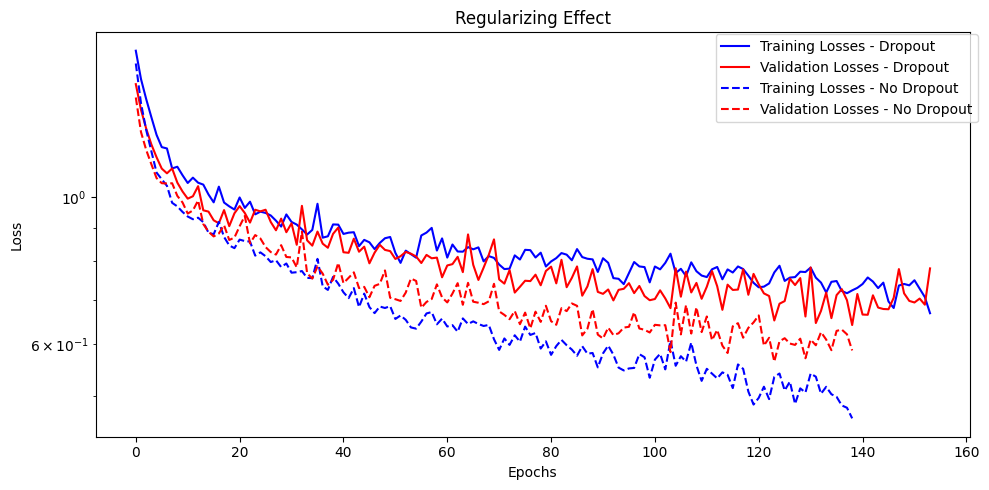

In [31]:
fig = figure11(arch_cnn2.losses, arch_cnn2.val_losses, arch_cnn2_nodrop.losses, arch_cnn2_nodrop.val_losses)

# Save the figure
fig.savefig('../images/personal_model/regularizing_effect_v4.png', dpi=300, bbox_inches='tight')

### Acurracy without the dropout

In [32]:
print('Correctly classified in train:',
    Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0),
    '\n','Correctly classified in val:',
    Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0)
)

Correctly classified in train: tensor([544, 657]) 
 Correctly classified in val: tensor([132, 165])


In [33]:
print("Accuracy in train:",
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0)),
    '\n','Accuracy in val:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0))
)

Accuracy in train: 0.8188736681887366 
 Accuracy in val: 0.8


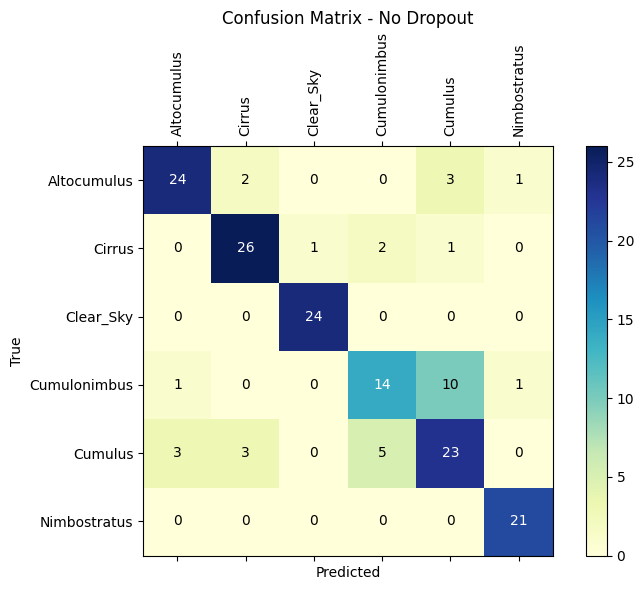

In [34]:
cm = confusion_matrix(val_loader, arch_cnn2_nodrop)

# Ploting the confusion matrix
def plot_confusion_matrix2(cm, classes, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm.numpy(), cmap=plt.cm.YlGnBu)
    fig.colorbar(cax)

    # Set axis labels
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

    # Set ticks and labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=90, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)

    # Annotate each cell with the numeric value
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j].item(), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    return fig

fig_cm = plot_confusion_matrix2(cm, arch_cnn2_nodrop.val_loader.dataset.classes,"Confusion Matrix - No Dropout")

# Save the cm image

fig_cm.savefig('../images/personal_model/C_matrix_nodrop_v3.png', dpi=300, bbox_inches='tight')

In [48]:
Architecture.loader_apply(val_loader,
                          arch_cnn2_nodrop.correct)

tensor([[23, 30],
        [23, 30],
        [24, 24],
        [21, 26],
        [21, 34],
        [16, 21]])

### Acurracy with Dropout

In [ ]:
print('Correctly classified in train:',
    Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0),
    '\n','Correctly classified in val:',
    Architecture.loader_apply(val_loader, arch_cnn2.correct)
)

In [ ]:
print('Accuracy in train:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0)),
    '\n','Accuracy in val:',
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0))
)

### Visualizing Filters

The conv1 filter visualization shows 3-channel (RGB) 3×3 kernels that learn low-level features such as edges and color gradients. These weights exhibit clear directional patterns and contrasts typical of early-layer feature detectors.

In contrast, the conv2 visualization displays 5-channel 3×3 kernels, with each channel corresponding to a feature map output from conv1. These filters capture more abstract, higher-order combinations of the first-layer features. The weights appear less interpretable in isolation, reflecting their role in integrating and recombining simpler patterns into more complex representations useful for classification.

This progression illustrates the hierarchical nature of CNNs: conv1 learns localized, low-level features, while conv2 composes them into richer, more discriminative abstractions.

In [45]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

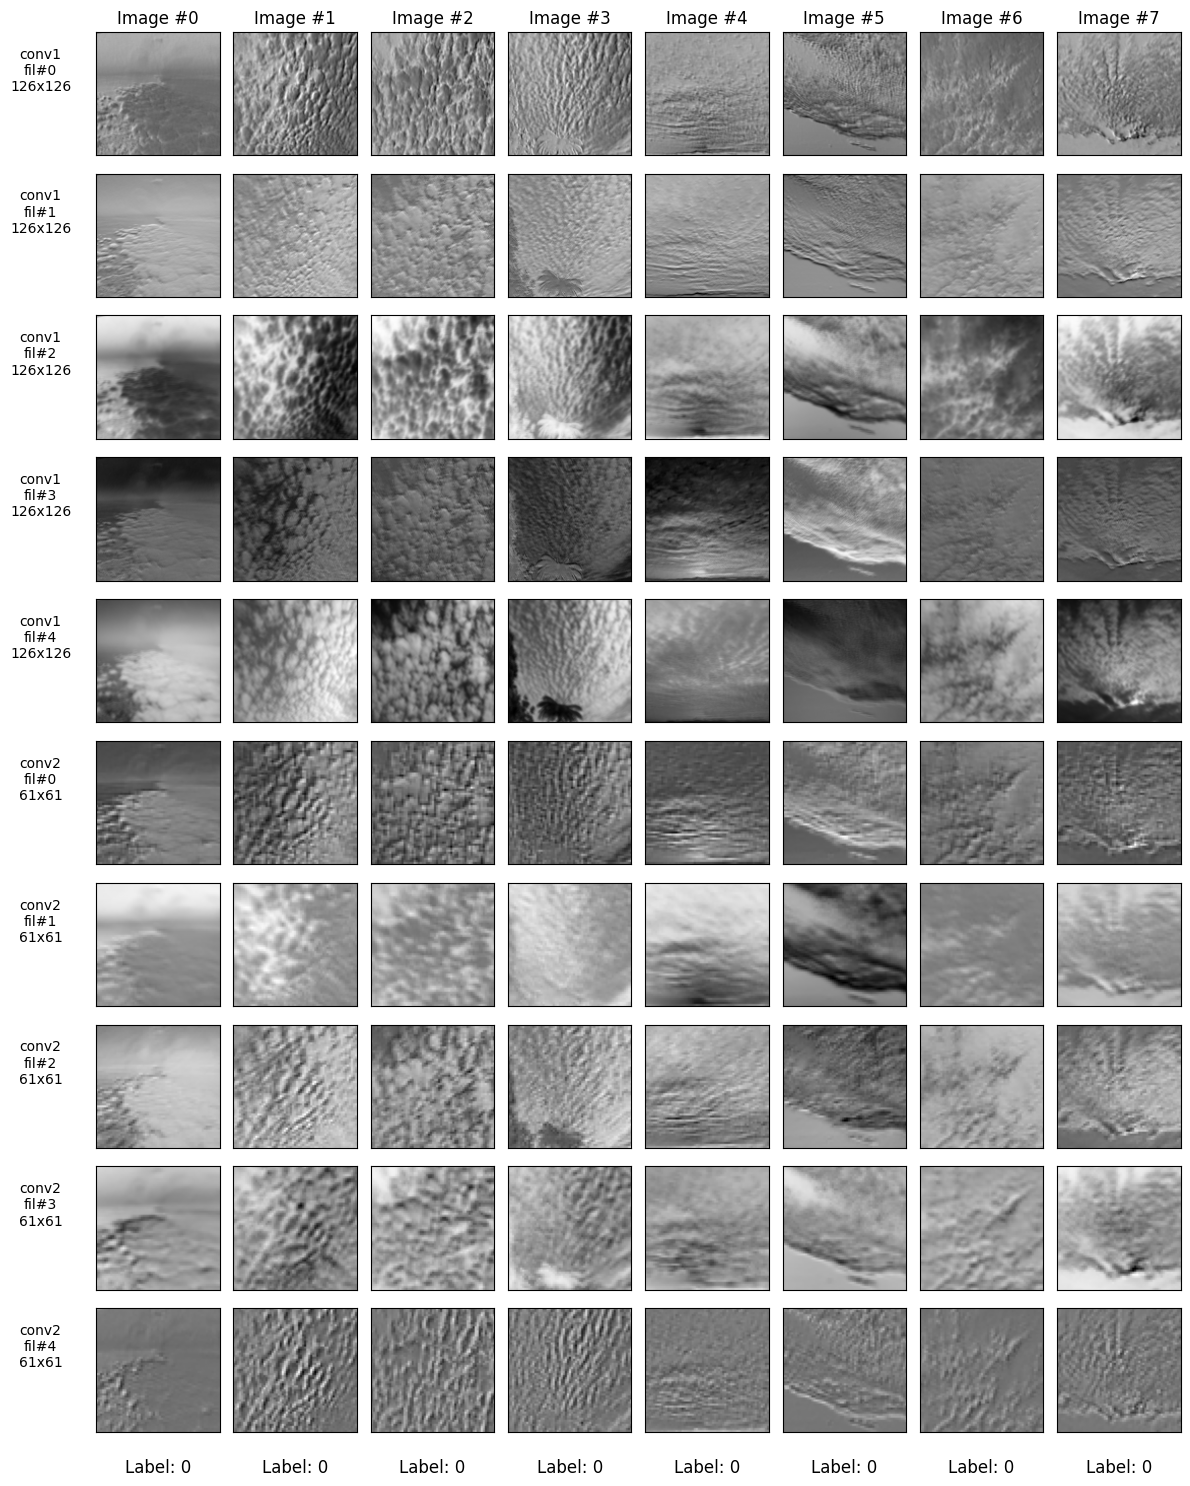

In [ ]:
# Inference to populate 'self.visualization':
x_batch, y_batch = next(iter(val_loader))
arch_cnn2.model.eval()
with torch.no_grad():
    yhat = arch_cnn2.model(x_batch.to(arch_cnn2.device))

# Attaching the hooks
arch_cnn2.attach_hooks(['conv1', 'conv2'])  
arch_cnn2.model(x_batch.to(arch_cnn2.device))
arch_cnn2.remove_hooks()

# Outputs plotting:
fig = arch_cnn2.visualize_outputs(['conv1','conv2'], n_images=8, y=y_batch)
plt.show()
fig.savefig('../images/personal_model/visualize_outputs_v3.png', dpi=300, bbox_inches='tight')

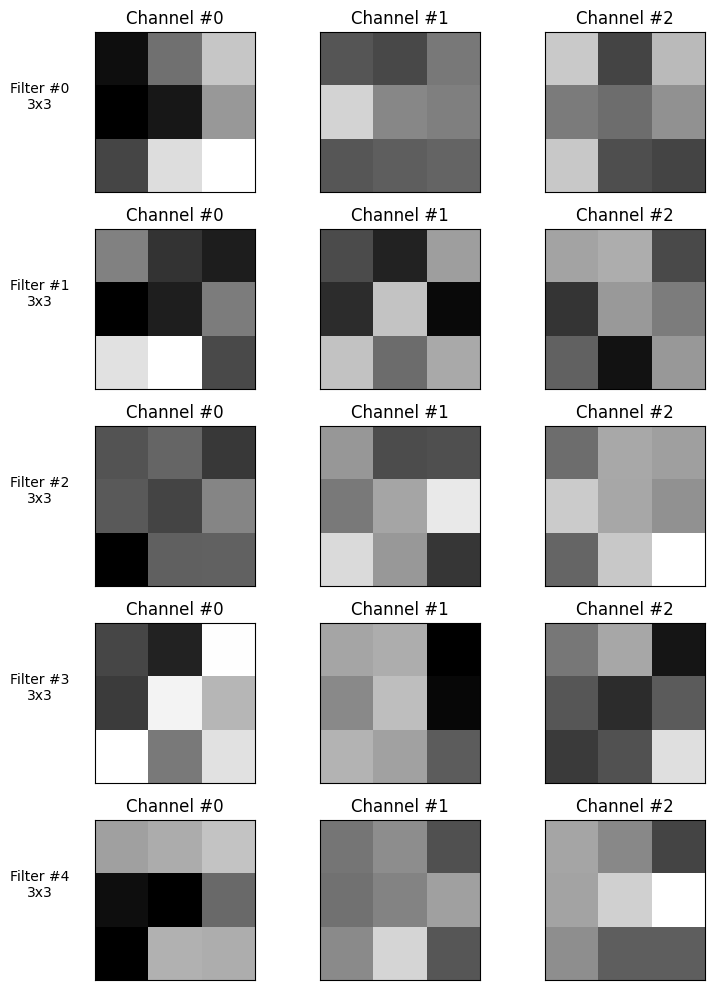

In [63]:
fig = arch_cnn2.visualize_filters('conv1')

fig.savefig('../images/personal_model/filters_conv1_v3.png', dpi=300, bbox_inches='tight')

In [47]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

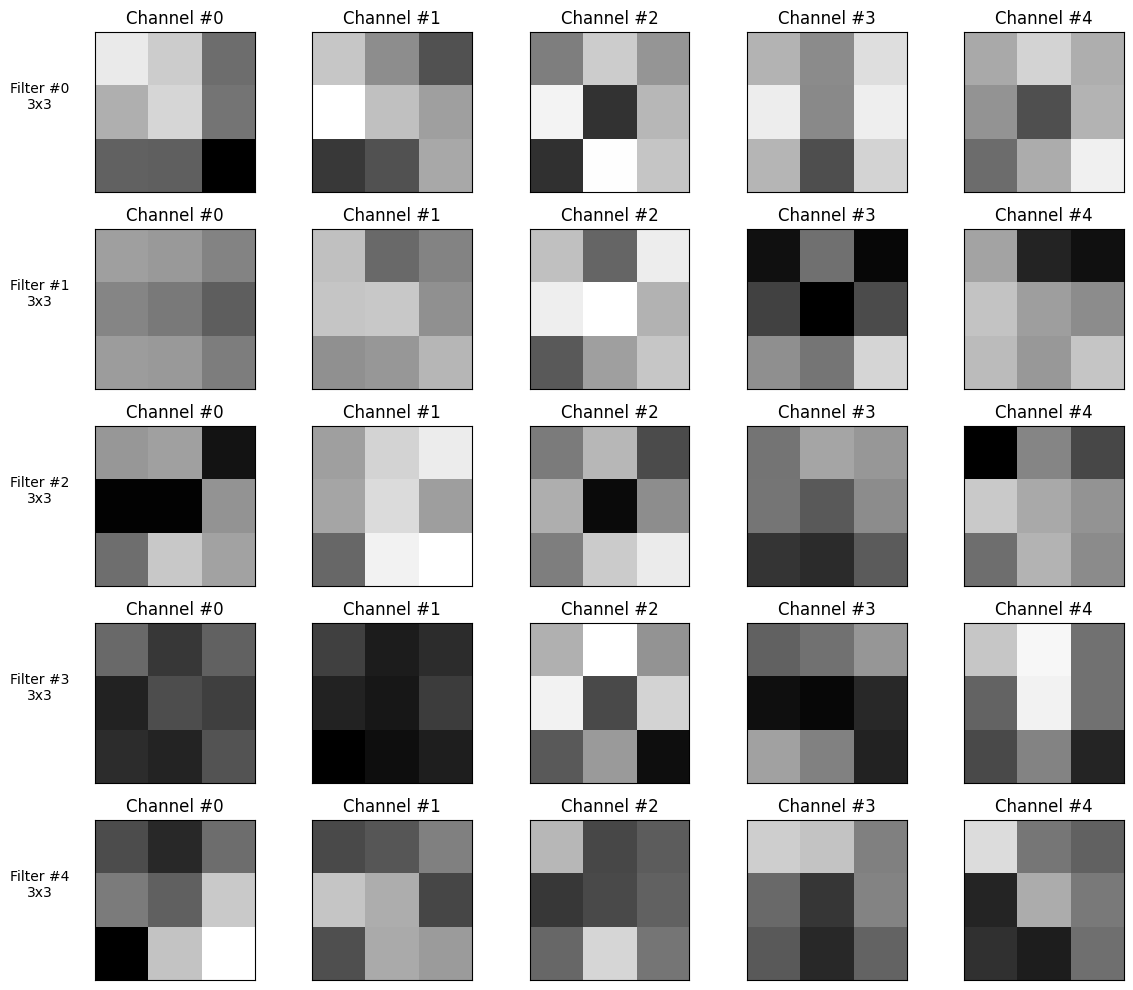

In [64]:
fig = arch_cnn2.visualize_filters('conv2')

fig.savefig('../images/personal_model/filters_conv2_v3.png', dpi=300, bbox_inches='tight')

In [ ]:
# Saving the model checkpoint

arch_cnn2.save_checkpoint("../models/personal_model_v3.pth")

arch_cnn2_nodrop.save_checkpoint("../models/personal_model_nodrop_v3.pth")